CASE 1

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import fsolve

def effective_saturation(S1, S1i, S2r):
    return (S1 - S1i) / (1 - S2r - S1i)

def kr1(S1, S1i, S2r, kr1max, a):
    Se = effective_saturation(S1, S1i, S2r)
    return kr1max * Se**a

def kr2(S1, S1i, S2r, kr2max, b):
    Se = effective_saturation(S1, S1i, S2r)
    return kr2max * (1 - Se)**b

def fractional_flow(S1, params):
    mu1, mu2, S1i, S2r, kr1max, kr2max, a, b = params
    kr1_val = kr1(S1, S1i, S2r, kr1max, a)
    kr2_val = kr2(S1, S1i, S2r, kr2max, b)
    
    # Handle potential division by zero
    if kr1_val == 0:
        kr1_val = 1e-10
    
    mobility_ratio = (mu1 / mu2) * (kr2_val / kr1_val)
    f1 = 1 / (1 + mobility_ratio)
    return f1

def f1(S1, mu1, mu2, Kr1max, Kr2max, a, b, S1i, S2r):
    Se = (S1 - S1i) / (1 - S2r - S1i)
    Kr1 = Kr1max * (Se ** a)
    Kr2 = Kr2max * ((1 - Se) ** b)
    epsilon = 1e-10  # Small number to avoid division by zero
    return 1.0 / (1.0 + ((mu1 / mu2) * (Kr2 / (Kr1 + epsilon))))

def df1_dS1(S1, params, delta=1e-3):
    # Numerical differentiation of fractional flow function
    f1_plus = fractional_flow(S1 + delta, params)
    f1_minus = fractional_flow(S1 - delta, params)
    return (f1_plus - f1_minus) / (2 * delta)

Get shock front

In [3]:
def find_shock_front(S1_inj, S1_init, params):
    """
    Find the shock front saturation using the equal-area rule
    """
    # Define the equal-area rule function to solve
    def equal_area_rule(S1_shock):
        # Calculate f'(S1_shock)
        slope_at_shock = df1_dS1(S1_shock, params)
        
        # Calculate fractional flow at injection and shock
        f1_inj = fractional_flow(S1_inj, params)
        f1_shock = fractional_flow(S1_shock, params)
        
        # Equal-area rule: (f1_inj - f1_shock) / (S1_inj - S1_shock) = slope_at_shock
        return (f1_inj - f1_shock) - slope_at_shock * (S1_inj - S1_shock)
    
    # Initial guess halfway between injection and initial saturation
    initial_guess = (S1_inj + S1_init) / 2
    
    # Solve for shock front saturation
    S1_shock = fsolve(equal_area_rule, initial_guess)[0]
    
    return S1_shock



Plot Fractional Flow

In [21]:
def plot_fractional_flow(params):
    """
    Plot the fractional flow curve and its derivative on the same plot
    to visualize the shock velocity intersection
    """
    mu1, mu2, S1i, S2r, kr1max, kr2max, a, b = params
    
    # Create saturation range
    S1_range = np.linspace(S1i, 1-S2r, 200)
    
    # Calculate fractional flow and its derivative
    f1_values = np.array([fractional_flow(S1, params) for S1 in S1_range])
    df1_values = np.array([df1_dS1(S1, params) for S1 in S1_range])

    #print the first five values of f1_values
    print(f1_values[:5])

    #print the first five values of df1_values
    print(df1_values[:5])

    #Remove all nan values
    f1_values = f1_values[1:]
    df1_values = df1_values[~np.isnan(df1_values)]
    #remove first value of S1_range
    S1_range = S1_range[1:]
    
    # Find shock front
    S1_inj = 1 - S2r
    S1_shock = find_shock_front(S1_inj, S1i, params)
    f1_shock = fractional_flow(S1_shock, params)
    
    # Calculate shock velocity
    shock_velocity = (f1_shock - 0) / (S1_shock - S1i) if S1_shock > S1i else 0
    
    # Plot
    plt.figure(figsize=(12, 10))
    
    # First subplot: Original fractional flow curve
    plt.subplot(2, 1, 1)
    plt.plot(S1_range, f1_values, 'b-', linewidth=2, label='Fractional Flow f1')
    #plt.plot([S1i, S1_shock, S1_inj], [0, f1_shock, 1], 'r--', linewidth=1.5, label='Shock Line')
    plt.scatter([S1_shock], [f1_shock], color='r', s=50)
    plt.xlabel('Saturation S1')
    plt.ylabel('Fractional Flow f1')
    plt.title('Fractional Flow Curve')
    plt.legend()
    plt.grid(True)
    
    # Second subplot: Both f1/S1 and df1/dS1 on the same plot
    plt.subplot(2, 1, 2)
    
    # Calculate f1/(S1-S1i) for S1 > S1i (avoiding division by zero)
    f1_S1_ratio = np.zeros_like(S1_range)
    for i, S1 in enumerate(S1_range):
        f1_S1_ratio[i] = f1_values[i] / (S1 - S1i)
        

    #print first five values of f1_S1_ratio
    print(f1_S1_ratio[:5])

    #print the first five values of df1_values
    print(df1_values[:5])

    abs_diff = np.abs(df1_values - f1_S1_ratio)

    #print first five values
    print(abs_diff[:5])

    min_index = np.argmin(abs_diff)
    #print the index of the minimum value
    print(min_index)

    S_intersect = S1_range[min_index]
    #print the value of the minimum value
    print(S_intersect)
    
    shock_velocity = df1_values[min_index]
    print(shock_velocity)
    
    plt.plot(S1_range, f1_S1_ratio, 'b-', linewidth=2, label='f1/(S1-S1i)')
    plt.plot(S1_range, df1_values, 'g-', linewidth=2, label='df1/dS1')
    
    # Mark the intersection point
    plt.scatter([S_intersect], [shock_velocity], color='r', s=50, zorder=5, label='Shock Front (Intersection)')
    plt.axhline(y=shock_velocity, color='r', linestyle='--', alpha=0.6)
    plt.axvline(x=S_intersect, color='r', linestyle='--', alpha=0.6)
    
    plt.xlabel('Saturation S1')
    plt.ylabel('Value (f1/(S1-S1i) and df1/dS1)')
    plt.title('Plot of f1/(S1-S1i) and df1/dS1 (Intersection Determines Shock Velocity)')
    plt.legend()
    plt.grid(True)
    
    # Add shock velocity information
    plt.text(0.5, 0.9, f'Shock Velocity = {shock_velocity:.4f}', 
             transform=plt.gca().transAxes, 
             bbox=dict(facecolor='white', alpha=0.8))
    
    plt.tight_layout()
    plt.show()

    # return shock_velocity, S_intersect
    return shock_velocity, S_intersect

Analytical Solution

In [22]:
def plot_analytical_S1_vs_vD_piecewise(shock_velocity, s_intersect, params):
    """
    Plot the analytical solution S1(v_D) (with v_D = x/t) in four segments:
    
    1. For 0 <= v_D <= vD_min, S1 = S_inj (constant horizontal line).
    2. For vD_min <= v_D <= vD_shock, S1 is given by the rarefaction (S1 such that df1/dS1 = v_D).
    3. At v_D = vD_shock, a vertical jump from S_shock (rarefaction end) to S1i.
    4. For v_D > vD_shock (up to a chosen v_max), S1 = S1i.
    
    The shock is determined by finding the intersection of df1/dS1 and f1/(S1-S1i).
    """
    import numpy as np
    import matplotlib.pyplot as plt
    
    # Unpack parameters
    mu1, mu2, S1i, S2r, kr1max, kr2max, a, b = params
    Sinj = 1 - S2r  # Injection saturation
    
    # Define helper functions for effective saturation and fractional flow are defined above
    # Here, we use the fractional_flow(S1, params) and df1_dS1(S1, params) functions.
    
    # Compute vD_min: derivative at injection saturation
    vD_min = df1_dS1(Sinj, params)
    
    S_shock = s_intersect
    vD_shock = shock_velocity # or ratio_vals[idx_shock]
    
    # --- Define helper function to find S1 for a given v_target using bisection ---
    def find_S1_for_v(v_target, S_min=S1i, S_max=Sinj, tol=1e-6):
        S_low = S_min
        S_high = S_max
        S_mid = (S_low + S_high)/2.0
        while (S_high - S_low) > tol:
            if df1_dS1(S_mid, params) < v_target:
                S_low = S_mid
            else:
                S_high = S_mid
            S_mid = (S_low + S_high) / 2.0
        return S_mid
    
    # --- Build the piecewise S1 vs v_D solution ---
    
    # Segment 1: v_D in [0, vD_min], S1 = Sinj (injection saturation)
    v_seg1 = np.linspace(0, vD_min, 50)
    S_seg1 = np.ones_like(v_seg1) * Sinj
    
    # Segment 2: v_D in [vD_min, vD_shock], S1 determined from rarefaction: S1 such that df1/dS1 = v_D
    # v_seg2 = np.linspace(vD_min, vD_shock, 100)
    # S_seg2 = np.array([find_S1_for_v(v, S_min=S1i, S_max=Sinj) for v in v_seg2])
    S_seg2 = np.linspace(s_intersect, Sinj, 100)
    v_seg2 = np.array([df1_dS1(s, params) for s in S_seg2])
    
    # Segment 3: vertical jump at v_D = vD_shock from S_shock (rarefaction end) to S1i (initial saturation)
    v_seg3 = np.array([vD_shock, vD_shock])
    S_seg3 = np.array([S_shock, S1i])
    
    # Segment 4: for v_D in [vD_shock, v_max], S1 = S1i (initial saturation)
    v_max = vD_shock + 1.0  # choose a v_max sufficiently larger (or a fixed value like 8)
    v_seg4 = np.linspace(vD_shock, v_max, 50)
    S_seg4 = np.ones_like(v_seg4) * S1i
    
    # --- Plot the piecewise solution ---
    plt.figure(figsize=(10,6))
    # Plot each segment
    #plt.plot(v_seg1, S_seg1, 'b-', linewidth=2, label='Segment 1 (Constant: S1 = Sinj)')
    plt.plot(v_seg2, S_seg2, 'g-', linewidth=2, label='Segment 1 (Rarefaction)')
    plt.plot(v_seg3, S_seg3, 'r-', linewidth=2, label='Segment 2 (Shock jump)')
    plt.plot(v_seg4, S_seg4, 'm-', linewidth=2, label='Segment 3 (Constant: S1 = S1i)')
    
    # Mark the shock intersection point
    plt.scatter([vD_shock], [S_shock], color='k', s=80, zorder=5, label=f'Shock: vD={vD_shock:.4f}, S1={S_shock:.4f}')
    
    plt.xlabel('v_D = x/t (dimensionless)')
    plt.ylabel('CO₂ Saturation, S1')
    plt.title('Analytical Buckley-Leverett Solution (Case 1): S1 vs. v_D')
    plt.legend(loc='best')
    plt.grid(True)
    plt.show()
    
    # Optionally, print the computed shock parameters:
    print(f"vD_min = {vD_min:.4f}, Shock at vD = {vD_shock:.4f} with S_shock = {S_shock:.4f}")


In [23]:
def main_analytical():
    # Parameters for Case 1
    mu1 = 0.1  # mPa.s (CO2)
    mu2 = 1.0  # mPa.s (Water)
    S1i = 0.0  # Initial saturation
    S2r = 0.2  # Residual saturation
    kr1max = 1.0
    kr2max = 1.0
    a = 1.2
    b = 3.0
    
    params = (mu1, mu2, S1i, S2r, kr1max, kr2max, a, b)
    
    # Plot modified fractional flow curve and get shock velocity and intersection
    shock_velocity, S_intersect = plot_fractional_flow(params)
    
   
    plot_analytical_S1_vs_vD_piecewise(shock_velocity, S_intersect, params)

/tmp/ipykernel_594846/3175456783.py:10: RuntimeWarning: invalid value encountered in scalar power
  return kr1max * Se**a


[9.99999999e-10 1.73908485e-02 3.96464232e-02 6.38358761e-02
 8.90806955e-02]
[       nan 5.15587059 5.82392089 6.17220469 6.36503608]
[4.32597356 4.93102388 5.29305806 5.53970575 5.71588666]
[5.15587059 5.82392089 6.17220469 6.36503608 6.46150945]
[0.82989703 0.89289701 0.87914663 0.82533034 0.74562278]
10
0.044221105527638194
6.111914756941034


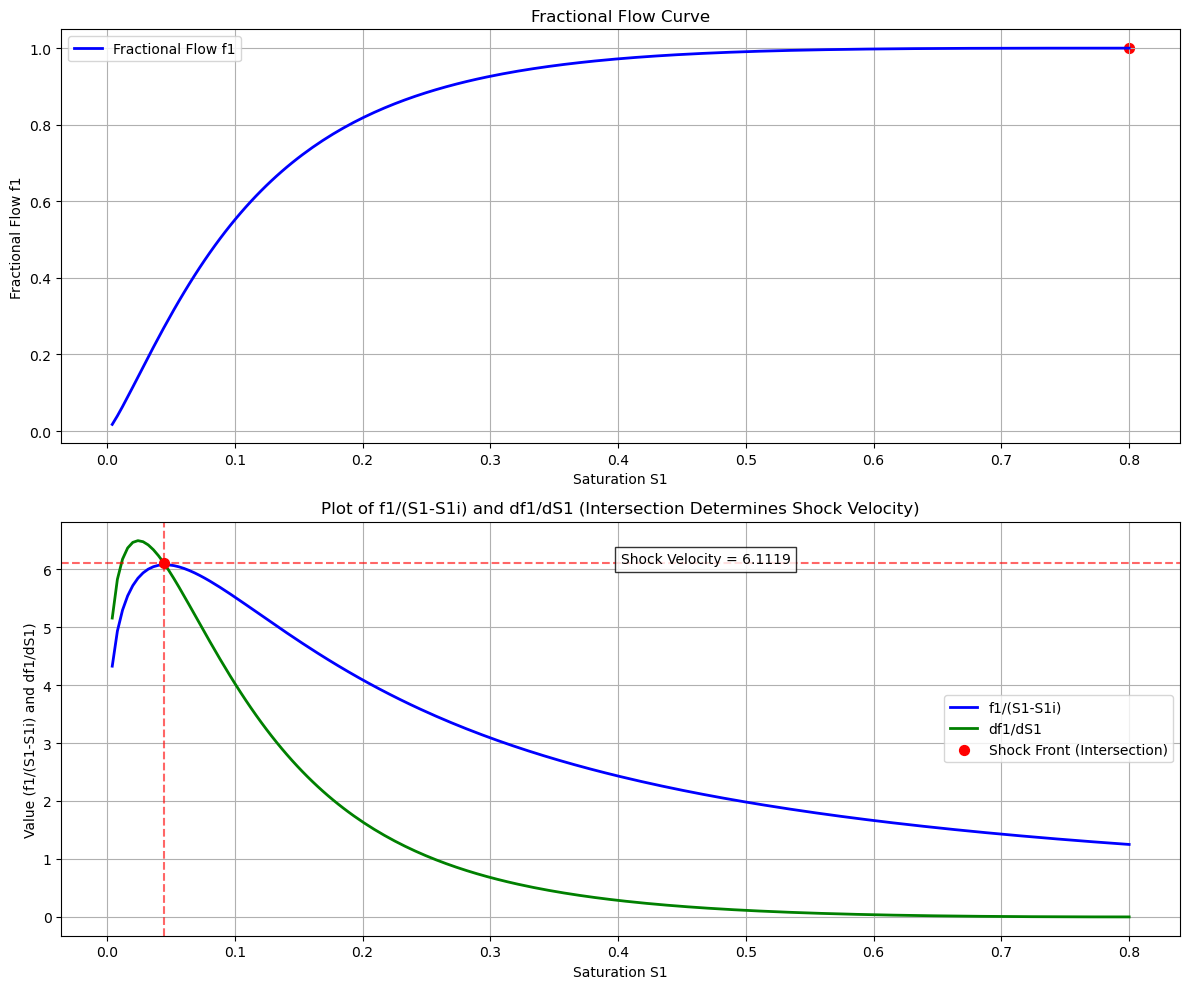

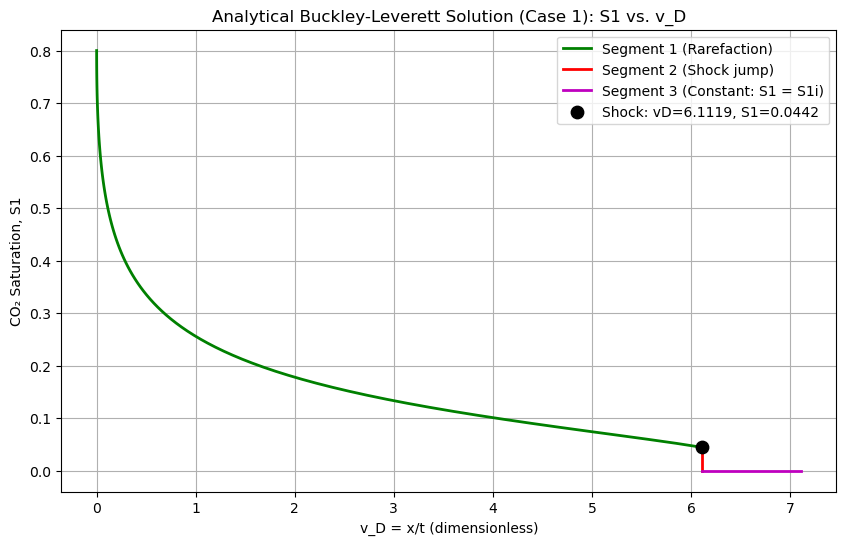

vD_min = 0.0000, Shock at vD = 6.1119 with S_shock = 0.0442


In [24]:
main_analytical()

Numerical Solution

In [8]:
from itertools import repeat

def grid_1(S1i, S2r, dt):
    grid = [1 - S2r] + list(repeat(S1i, 100))
    dx = 1 / (len(grid) - 1)
    return np.array(grid), dx

In [9]:
def f1(S1, mu1, mu2, Kr1max, Kr2max, a, b, S1i, S2r):
    Se = (S1 - S1i) / (1 - S2r - S1i)
    Kr1 = Kr1max * (Se ** a)
    Kr2 = Kr2max * ((1 - Se) ** b)
    epsilon = 1e-10  # Small number to avoid division by zero
    return 1.0 / (1.0 + ((mu1 / mu2) * (Kr2 / (Kr1 + epsilon))))

In [10]:
def fractional_flow1(S1, params):
    mu1, mu2, S1i, S2r, kr1max, kr2max, a, b = params
    kr1_val = kr1(S1, S1i, S2r, kr1max, a)
    kr2_val = kr2(S1, S1i, S2r, kr2max, b)
    
    epsilon = 1e-10
    
    mobility_ratio = (mu1 / mu2) * (kr2_val / (kr1_val + epsilon))
    f1 = 1 / (1 + mobility_ratio)
    return f1

In [11]:
def model(mu1, mu2, kr1max, kr2max, a, b, S1i, S2r, dt, n):
    params = (mu1, mu2, S1i, S2r, kr1max, kr2max, a, b)
    grid, dx = grid_1(S1i, S2r, dt)
    final = [grid.copy()]
    for _ in range(n):
        #ff_flow = [1] + [f1(S, mu1, mu2, kr1max, kr2max, a, b, S1i, S2r) for S in grid[1:]]
        # Do ff_flow in terms of fractional_flow1
        ff_flow = [1] + [fractional_flow1(S, params) for S in grid[1:]]
        S_new = np.zeros_like(grid)
        S_new[0] = 1 - S2r
        for i in range(1, len(grid)):
            S_new[i] = grid[i] + (ff_flow[i-1] - ff_flow[i]) * (dt * 0.95 / dx)
        final.append(S_new.copy())
        grid = S_new
    return np.array(final), dx

In [25]:
def plot_numerical(S1i, S2r, mu1, mu2, Kr1max, Kr2max, a, b, dt, n):
    sat_final, dx = model(mu1, mu2, Kr1max, Kr2max, a, b, S1i, S2r, dt, n)
    sat_final = sat_final[-1]
    Vd_final = [((i - 0.5) * (dx / (100 * dt))) for i in range(101)]
    Vd_final[0] = 0
    plt.figure(figsize=(10, 6))
    plt.plot(Vd_final, sat_final, color='black', label='Numerical')
    plt.title('Numerical Solution of Buckley-Leverett Equation (Case 1)')
    plt.xlabel('Dimensionless Velocity, Vd')
    plt.ylabel('Saturation, S')
    plt.xlim(0, 10)
    plt.legend()
    plt.grid(True)
    plt.show()

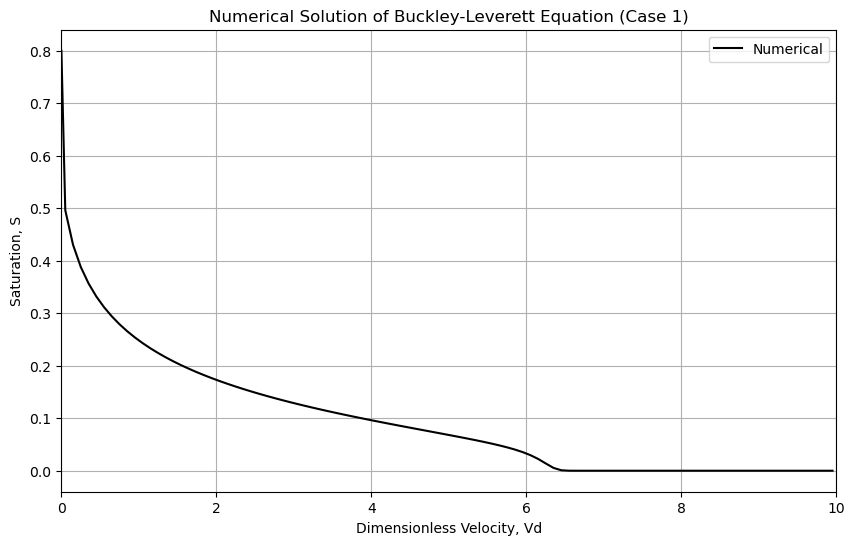

In [26]:
# Simulation parameters
mu1 = 0.1e-3
mu2 = 1e-3
Kr1max = 1
Kr2max = 1
a = 1.2
b = 3
S1i = 0
S2r = 0.2
dt = 0.001
n = 100  # Number of time steps
 
 
case = "Case1"
phase1 = '$CO_{2}$'
phase2 = 'Water'
S1_val1 = np.linspace(S1i, 1 - S2r, 100000)
 
plot_numerical(S1i, S2r, mu1, mu2, Kr1max, Kr2max, a, b, dt, n)

Comparison

In [14]:
# Simulation parameters
mu1 = 0.1e-3
mu2 = 1e-3
Kr1max = 1
Kr2max = 1
a = 1.2
b = 3
S1i = 0
S2r = 0.2
dt = 0.001
n = 100  # Number of time steps

In [29]:
def plot_analytical_S1_vs_vD_piecewise_and_numerical(shock_velocity, s_intersect, params, dt, n):
    """
    Plot the analytical solution S1(v_D) (with v_D = x/t) in four segments:
    
    1. For 0 <= v_D <= vD_min, S1 = S_inj (constant horizontal line).
    2. For vD_min <= v_D <= vD_shock, S1 is given by the rarefaction (S1 such that df1/dS1 = v_D).
    3. At v_D = vD_shock, a vertical jump from S_shock (rarefaction end) to S1i.
    4. For v_D > vD_shock (up to a chosen v_max), S1 = S1i.
    
    The shock is determined by finding the intersection of df1/dS1 and f1/(S1-S1i).
    """
    import numpy as np
    import matplotlib.pyplot as plt
    
    # Unpack parameters
    mu1, mu2, S1i, S2r, kr1max, kr2max, a, b = params
    Sinj = 1 - S2r  # Injection saturation
    
    # Define helper functions for effective saturation and fractional flow are defined above
    # Here, we use the fractional_flow(S1, params) and df1_dS1(S1, params) functions.
    
    # Compute vD_min: derivative at injection saturation
    vD_min = df1_dS1(Sinj, params)
    
    S_shock = s_intersect
    vD_shock = shock_velocity # or ratio_vals[idx_shock]
    
    # --- Define helper function to find S1 for a given v_target using bisection ---
    def find_S1_for_v(v_target, S_min=S1i, S_max=Sinj, tol=1e-6):
        S_low = S_min
        S_high = S_max
        S_mid = (S_low + S_high)/2.0
        while (S_high - S_low) > tol:
            if df1_dS1(S_mid, params) < v_target:
                S_low = S_mid
            else:
                S_high = S_mid
            S_mid = (S_low + S_high) / 2.0
        return S_mid
    
    # --- Build the piecewise S1 vs v_D solution ---
    
    # Segment 1: v_D in [0, vD_min], S1 = Sinj (injection saturation)
    v_seg1 = np.linspace(0, vD_min, 50)
    S_seg1 = np.ones_like(v_seg1) * Sinj
    
    # Segment 2: v_D in [vD_min, vD_shock], S1 determined from rarefaction: S1 such that df1/dS1 = v_D
    # v_seg2 = np.linspace(vD_min, vD_shock, 100)
    # S_seg2 = np.array([find_S1_for_v(v, S_min=S1i, S_max=Sinj) for v in v_seg2])
    S_seg2 = np.linspace(s_intersect, Sinj, 100)
    v_seg2 = np.array([df1_dS1(s, params) for s in S_seg2])
    
    # Segment 3: vertical jump at v_D = vD_shock from S_shock (rarefaction end) to S1i (initial saturation)
    v_seg3 = np.array([vD_shock, vD_shock])
    S_seg3 = np.array([S_shock, S1i])
    
    # Segment 4: for v_D in [vD_shock, v_max], S1 = S1i (initial saturation)
    v_max = vD_shock + 1.0  # choose a v_max sufficiently larger (or a fixed value like 8)
    v_seg4 = np.linspace(vD_shock, v_max, 50)
    S_seg4 = np.ones_like(v_seg4) * S1i
    
    # --- Plot the piecewise solution ---
    plt.figure(figsize=(10,6))
    # Plot each segment
    #plt.plot(v_seg1, S_seg1, 'b-', linewidth=2, label='Segment 1 (Constant: S1 = Sinj)')
    plt.plot(v_seg2, S_seg2, 'g-', linewidth=2, label='Analytical Solution')
    plt.plot(v_seg3, S_seg3, 'g-', linewidth=2)
    plt.plot(v_seg4, S_seg4, 'g-', linewidth=2)
    
    # Mark the shock intersection point
    plt.scatter([vD_shock], [S_shock], color='k', s=80, zorder=5, label=f'Shock: vD={vD_shock:.4f}, S1={S_shock:.4f}')

    #Plot the numerical solution
    sat_final, dx = model(mu1, mu2, kr1max, kr2max, a, b, S1i, S2r, dt, n)
    sat_final = sat_final[-1]
    Vd_final = [((i - 0.5) * (dx / (100 * dt))) for i in range(101)]
    Vd_final[0] = 0
    plt.plot(Vd_final, sat_final, color='black', label='Numerical Solution')
    
    plt.xlabel('v_D = x/t (dimensionless)')
    plt.ylabel('CO₂ Saturation, S1')
    plt.title('Comparison of Analytical and Numerical Buckley-Leverett Solution: S1 vs. v_D (Case 1)')
    plt.legend(loc='best')
    plt.grid(True)
    plt.show()
    
    # Optionally, print the computed shock parameters:
    print(f"vD_min = {vD_min:.4f}, Shock at vD = {vD_shock:.4f} with S_shock = {S_shock:.4f}")


In [16]:
def main_analytical_numerical():
    # Parameters for Case 1
    mu1 = 0.1e-3  # mPa.s (CO2)
    mu2 = 1.0e-3  # mPa.s (Water)
    S1i = 0.0  # Initial saturation
    S2r = 0.2  # Residual saturation
    kr1max = 1.0
    kr2max = 1.0
    a = 1.2
    b = 3.0
    dt = 0.001
    n = 100  # Number of time steps
    
    params = (mu1, mu2, S1i, S2r, kr1max, kr2max, a, b)
    
    # Plot modified fractional flow curve and get shock velocity and intersection
    shock_velocity, S_intersect = plot_fractional_flow(params)
    
   
    plot_analytical_S1_vs_vD_piecewise_and_numerical(shock_velocity, S_intersect, params, dt, n)

/tmp/ipykernel_594846/3175456783.py:10: RuntimeWarning: invalid value encountered in scalar power
  return kr1max * Se**a


[9.99999999e-10 1.73908485e-02 3.96464232e-02 6.38358761e-02
 8.90806955e-02]
[       nan 5.15587059 5.82392089 6.17220469 6.36503608]
[4.32597356 4.93102388 5.29305806 5.53970575 5.71588666]
[5.15587059 5.82392089 6.17220469 6.36503608 6.46150945]
[0.82989703 0.89289701 0.87914663 0.82533034 0.74562278]
10
0.044221105527638194
6.111914756941034


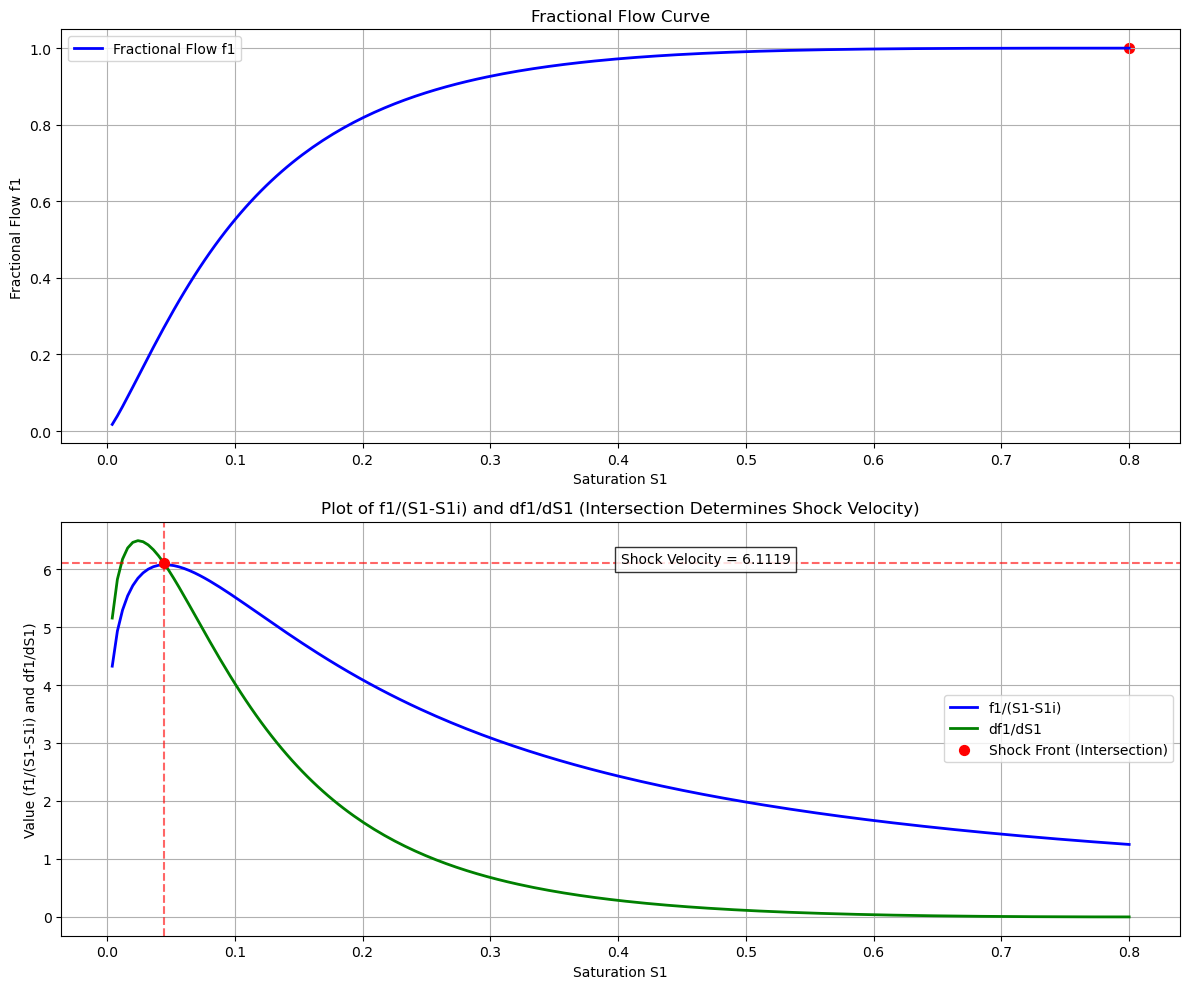

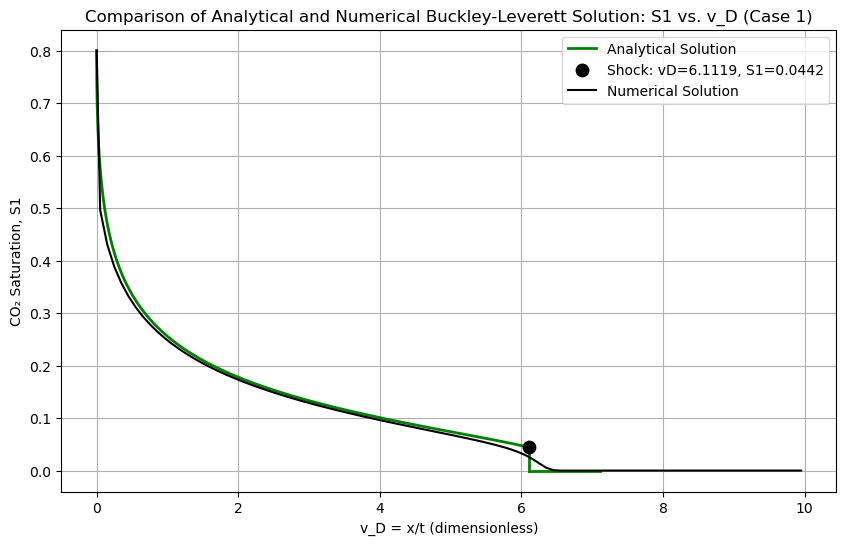

vD_min = 0.0000, Shock at vD = 6.1119 with S_shock = 0.0442


In [30]:
main_analytical_numerical()